In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer, make_column_transformer
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [4]:
# This is to clean text from new lines, etc.
def clean_context(context):
    
    myPattern = r'\s*{match}'.format(match='\n')
    p = re.compile(myPattern)
    spans_to_remove = []
    for match in p.finditer(context.lower()):   
        spans_to_remove.append(match.span())
    
    clean_context = ''
    clean_index = 0
    for span in spans_to_remove:
        index = span[1]
        while (index<len(context)-1) and (context[index] != ' ') and (context[index] != "\n"):
            index += 1
        clean_context += context[clean_index:span[0]]
        clean_index = index
    clean_context += context[clean_index:]
    clean_context = clean_context.translate(str.maketrans('', '', string.punctuation))
    
    return clean_context.strip()

In [5]:
def cosine_similarity(a, b):
    norm_product = np.linalg.norm(a, axis=0) * np.linalg.norm(b, axis=0)
    return np.array(a) @ np.array(b).T / norm_product

I have converted the title and body of each post to embeddings and save it in a parquet file

In [6]:
restored_data = pd.read_parquet('reddit.parquet.gzip', engine='pyarrow')

## cleaning the text
I cleaned the text in the both body and title by the clean_context function

In [8]:
restored_data['body'] = restored_data['body'].map(clean_context)
restored_data['title'] = restored_data['title'].map(clean_context)

## checking the score
Here in the boxplot below we can see that the score has some serious outliers!

<Axes: ylabel='score'>

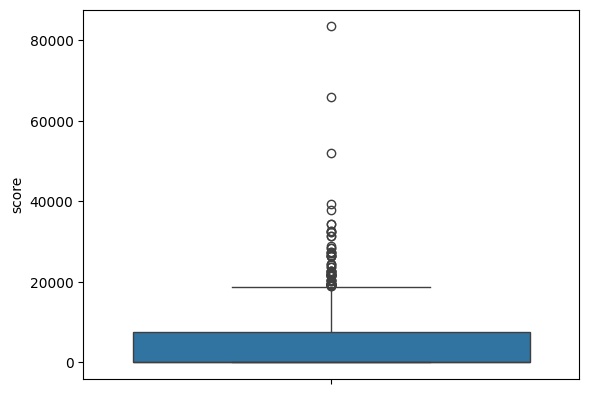

In [9]:
sns.boxplot(restored_data['score'])

I removed the outliers

In [10]:
restored_data = restored_data[restored_data['score'] <= 20000]

Also, we can see that a considerable portion of data does not have a body attached. There is a very interesting relationship between not having body and score

In [11]:
print(f"{len(restored_data[restored_data['body'] == ''])/len(restored_data)*100:.2f}% of dataset does not have body", )

40.47% of dataset does not have body


<Axes: ylabel='score'>

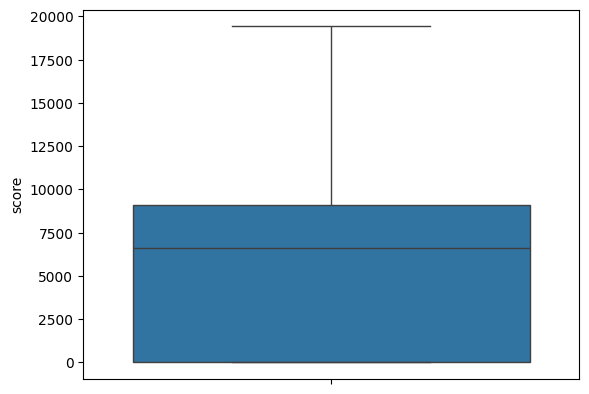

In [12]:
sns.boxplot(restored_data[restored_data['body'] == '']['score'])

<Axes: ylabel='score'>

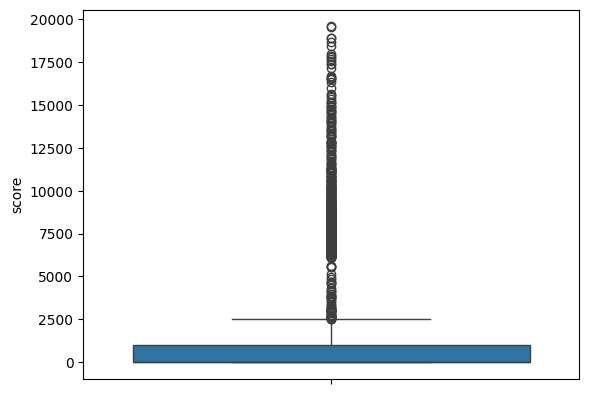

In [13]:
sns.boxplot(restored_data[restored_data['body'] != '']['score'])

In [14]:
restored_data[restored_data['body'] == '']['score'].median()

6615.0

In [15]:
restored_data[restored_data['body'] != '']['score'].median()

11.0

We can clearly see from the boxplots above that whether the post has a body would highly affect the score. The median score of posts without body is 6615.0, while it is only 11 for those with body. So I decided to partition the prediction model over the dataset. I essentially train two models one with body and one without body.

In [16]:
with_body = restored_data[restored_data['body'] != '']
without_body = restored_data[restored_data['body'] == '']

I was wondering also, if the correlation between the title and body for those posts containing body would have any close correlation with the score

In [17]:
cosine = []
for (index, row) in with_body.iterrows():
    cosine.append(cosine_similarity(row['title_emb'], row['body_emb']))

In [18]:
with_body['title_body_sim'] = cosine

/var/folders/z8/q_507x9n2z106trzz88jk2vr0000gn/T/ipykernel_4669/2221520169.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  with_body['title_body_sim'] = cosine


In [19]:
with_body[['score', 'title_body_sim', 'upvote_ratio']].corr()

,score,title_body_sim,upvote_ratio
score,1.000000,-0.091879,0.536360
title_body_sim,-0.091879,1.000000,0.010318
upvote_ratio,0.536360,0.010318,1.000000


We can see that score has a high correlation with upvote_ratio (as expected) while a small negative correlation with similarity between title and body. Again, an interesting finding. Looks like people get attracted more to the posts with body not in the same line as the title! 

## Training model for posts without body

First I will train model over the dataset without body. I use scikitlearn library to select the model and the evaluate the model. Here I used linearRegression and RandomForestRegression. The title has been vectorized using tfidf. The embeddings can be also used instead of the tfidf features. However, I think tfidf can provide us with more insights into what words may influence the scores. I also included the tag in the features, and converted it to one hot encoding vector. As we saw the high correlation between upvote_ratio, it is also included in the features.

In [39]:
transformer = make_column_transformer((CountVectorizer(stop_words = 'english'), 'title'),
                                      (OneHotEncoder(), 'tag'), 
                                       remainder='passthrough')

In [40]:
Features = ['title', 'tag', 'upvote_ratio']

In [41]:
#linear regression
lr_pipeline = Pipeline([
    ('trans', transformer),
    ('clf', LinearRegression())
])

In [42]:
#Random Forest Regression 
RFR_pipeline = Pipeline([
    ('trans', transformer),
    ('clf', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [43]:
x, y = without_body[Features], without_body['score']

I first do cross-validation to pick the better model based on R2 score. 

In [44]:
folds = 10
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1/folds), random_state=0)
cv = KFold(n_splits=(folds - 1))

In [45]:
scores = cross_val_score(lr_pipeline, x_train, y_train, cv = cv, scoring= 'r2')
print(f"r2 scores of linear regression model: {scores}")
scores = cross_val_score(RFR_pipeline, x_train, y_train, cv = cv, scoring= 'r2')
print(f"r2 scores of reandom forest regression model: {scores}")

r2 scores of linear regression model: [0.31068602 0.22109581 0.31566612 0.20567921 0.36609438 0.55635242
 0.32377387 0.36500511 0.31264044]
r2 scores of reandom forest regression model: [0.68435589 0.63463671 0.66893239 0.68075401 0.65188158 0.65224547
 0.7066167  0.73613025 0.77024931]


We can see that r2 scores of random forest regression model is much higher, and therefore I select it for predicting scores for our without body dataset. We can also take a look at prediction for a validation set as below (for both models). Comparatively, we can see the random forest prediction is more aligned with actual scores.

In [46]:
#split the data again, this time we train only on tain set, validate on validation set, and have an hold out set as test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) 

# predicting with linear regression
lr_pipeline.fit(x_train, y_train)
lr_y_pred_train = lr_pipeline.predict(x_train)
lr_y_pred_val = lr_pipeline.predict(x_val)
lr_y_pred_val[lr_y_pred_val < 0] = 0

# predicting with random forest regression
RFR_pipeline.fit(x_train, y_train)
rfr_y_pred_train = RFR_pipeline.predict(x_train)
rfr_y_pred_val = RFR_pipeline.predict(x_val)
rfr_y_pred_val[rfr_y_pred_val < 0] = 0

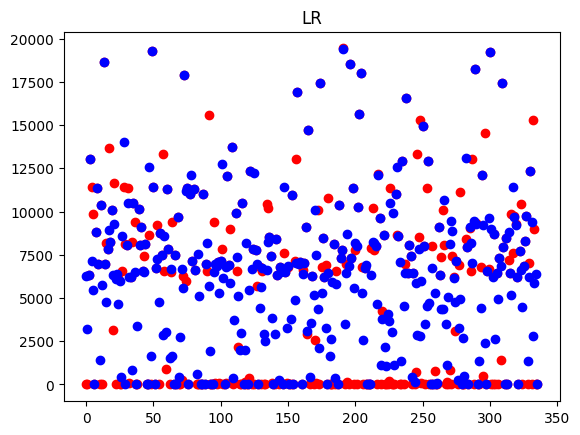

In [47]:
plt.scatter(np.arange(0,len(y_val)), y_val.values, c = 'r')
plt.scatter(np.arange(0,len(y_val)), lr_y_pred_val, c = 'b')
plt.title("LR")
plt.show()

using random forest regression model, predicting scores on the test set would be as follows

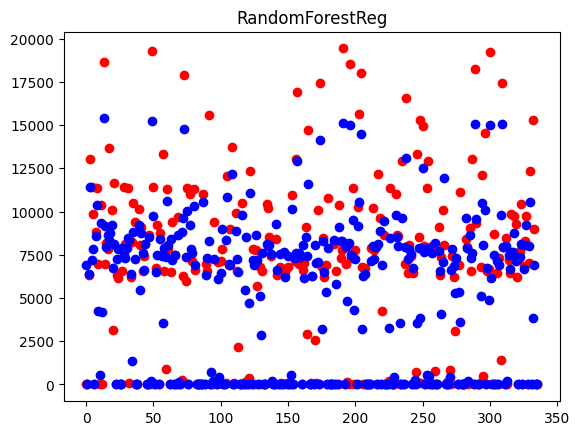

In [48]:
plt.scatter(np.arange(0,len(y_val)), y_val.values, c = 'r')
plt.scatter(np.arange(0,len(y_val)), rfr_y_pred_val, c = 'b')
plt.title("RandomForestReg")
plt.show()

using random forest regression model, predicting scores on the test set would be as follows

In [49]:
y_pred = RFR_pipeline.predict(x_test)
y_pred[y_pred < 0] = 0
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Square Error (RMSE): {rmse}")

Root Mean Square Error (RMSE): 3177.3757647479615


the RMSE is unfortunately still high, due to the high variance in the scores. Here, I would like to show important features affecting the score

In [51]:
df = pd.DataFrame(transformer.fit_transform(x_train).toarray())
df['target'] = y_train.values
X = df.drop("target", axis=1)
y = df["target"]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
print(feature_importance.sort_values(by='Importance', ascending=False))

     Feature  Importance
3338    3338    0.533017
2000    2000    0.005284
892      892    0.005025
1297    1297    0.004957
2890    2890    0.004910
...      ...         ...
384      384    0.000000
379      379    0.000000
2671    2671    0.000000
1640    1640    0.000000
881      881    0.000000

[3339 rows x 2 columns]


In [53]:
important_features = feature_importance.sort_values(by='Importance', ascending=False).index[0:20]
for i in important_features:
    print(RFR_pipeline.named_steps["trans"].get_feature_names_out()[i])

remainder__upvote_ratio
countvectorizer__nose
countvectorizer__does
countvectorizer__globally
countvectorizer__surrounding
countvectorizer__difference
countvectorizer__loop
countvectorizer__dna
onehotencoder__tag_7
countvectorizer__fish
countvectorizer__happened
countvectorizer__melt
countvectorizer__survive
countvectorizer__cure
countvectorizer__capillary
countvectorizer__happens
countvectorizer__alphabet
countvectorizer__covid19
countvectorizer__oxygen
countvectorizer__compounds


## Training model for posts with body

In [55]:
transformer = make_column_transformer((CountVectorizer(stop_words = 'english'), 'title'),
                                      (CountVectorizer(stop_words = 'english'), 'body'),
                                      (OneHotEncoder(), 'tag'), 
                                       remainder='passthrough')

In [56]:
Features = ['title', 'body', 'tag', 'title_body_sim', 'upvote_ratio']

In [57]:
lr_pipeline = Pipeline([
    ('trans', transformer),
    ('clf', LinearRegression())
])

In [58]:
#Random Forest Regression 
RFR_pipeline = Pipeline([
    ('trans', transformer),
    ('clf', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [59]:
x, y = with_body[Features], with_body['score']

In [60]:
folds = 10
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1/folds), random_state=0)
cv = KFold(n_splits=(folds - 1))

In [61]:
scores = cross_val_score(lr_pipeline, x_train, y_train, cv = cv, scoring= 'r2')
print(f"r2 scores of linear regression model: {scores}")
scores = cross_val_score(RFR_pipeline, x_train, y_train, cv = cv, scoring= 'r2')
print(f"r2 scores of reandom forest regression model: {scores}")

r2 scores of linear regression model: [ 0.06000734  0.13871981  0.13233926  0.16326245 -0.07159778 -0.12249095
  0.15102817 -0.13533351  0.0663065 ]
r2 scores of reandom forest regression model: [0.31840165 0.46592042 0.38071387 0.51200934 0.43280319 0.27644176
 0.58121472 0.4838399  0.52109197]


we can see that the r2 scores are much worse with linear regression. The model does not follow the trend of data.
Random Forest regression performs much better. Probably because of different scale of input/output especially scores, and outliers in the data. Linear regression is sensitive to outliers and is scale-variant. 

In [62]:
#split the data again, this time we train only on tain set, validate on validation set, and have an hold out set as test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) 

# predicting with random forest regression
RFR_pipeline.fit(x_train, y_train)
rfr_y_pred_train = RFR_pipeline.predict(x_train)
rfr_y_pred_val = RFR_pipeline.predict(x_val)
rfr_y_pred_val[rfr_y_pred_val < 0] = 0

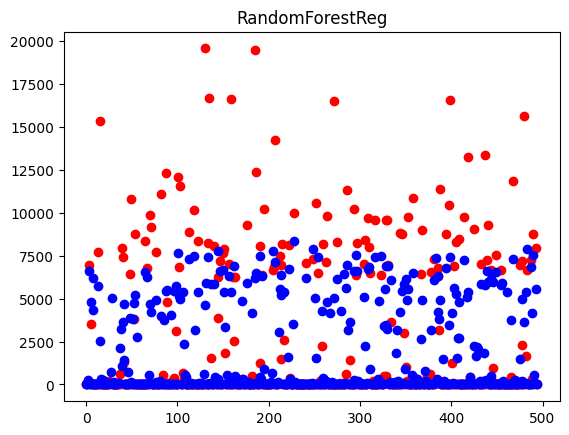

In [63]:
plt.scatter(np.arange(0,len(y_val)), y_val.values, c = 'r')
plt.scatter(np.arange(0,len(y_val)), rfr_y_pred_val, c = 'b')
plt.title("RandomForestReg")
plt.show()

In [64]:
y_pred = RFR_pipeline.predict(x_test)
y_pred[y_pred < 0] = 0
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Square Error (RMSE): {rmse}")

Root Mean Square Error (RMSE): 2460.256473104897


However, the RMSE is not too bad compared to the data without body. Overall, the model has a hard time following the high scores which are less likely to happen. 